# Overview
1. Import data
2. EDA
3. Define functions
4. Data cleaning
5. Feature engineering
6. Modeling
7. Evaluation

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score
)


In [3]:
test = pd.read_csv(r"C:\Users\mcdonnelldeclan\Downloads\test.csv")
train = pd.read_csv(r"C:\Users\mcdonnelldeclan\Downloads\train.csv")
test_features = pd.read_csv(r"C:\Users\mcdonnelldeclan\Downloads\test_features.csv")
train_features = pd.read_csv(r"C:\Users\mcdonnelldeclan\Downloads\train_features.csv")
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

## EDA
Description here

In [4]:
# what dates is the dataset for?
    # All of 2016
    # train.timestamp.max()

In [5]:
# what is the time interval?
    # hourly, with no missing data or outliers (8784 hourly readings = 366 days in the year))
    # timestamps = train['timestamp'].drop_duplicates().diff()
    # timestamps.describe()

In [6]:
# how many buildings in the dataset?
    # 200 buildings, around half with all readings, and a minimum of ~311 days (7471 hourly readings)
    # train['building_id'].value_counts(sort=True).describe()

In [7]:
# how many anomalous datapoints?
    # 37296, or 2.1%
    # train.value_counts(subset='anomaly')

## Define functions
description here

In [8]:
# for each building, create an IQR and label each point as an anomaly or not
    # define a function that takes a building, creates an IQR, and labels each datapoint as anomalous or not
    # for each bldg, calc IQR and upper/lower bounds

def plot_anomalies(df, building_id, pred_anomaly):
    """
    Take any building you want and plot what it looks like with the predicted anomalies labeled
    """
    df[df['building_id'] == building_id].plot(kind='scatter', x='timestamp', y='meter_reading', figsize=(12,6)
                                              , c=pred_anomaly, colormap='Paired'
                                              , title=f'meter readings for building {building_id}')

def eval_metrics(df, pred_anomaly, building_id=None):
    """
    Take a dataframe and calculate the accuracy, precision, recall, F1 score, and AUC
    """
    eval_df = df[df['building_id']==building_id].copy() if building_id is not None else df.copy()

    accuracy = accuracy_score(eval_df['anomaly'], eval_df[pred_anomaly])
    precision = precision_score(eval_df['anomaly'], eval_df[pred_anomaly])
    recall = recall_score(eval_df['anomaly'], eval_df[pred_anomaly])
    f1 = f1_score(eval_df['anomaly'], eval_df[pred_anomaly])
    
    if building_id is not None:
        print('Building ID: ', building_id)
    print('Accuracy: ', round(accuracy * 100, 2), '%')
    print('Recall: ', round(recall * 100, 2), '%')
    print('Precision: ', round(precision * 100, 2), '%')
    print('F1 Score: ', round(f1 * 100, 2), '%')

def label_anomalies_iqr(df):

    """
    Takes a dataset of buildings and meter readings. For each building, calculates Q3/Q1/IQR and upper/lower limits 
    of where outliers are. It then uses those limits to label a new column called pred_anomaly_iqr as 1/0.
    """
    # do the calcs
    readings = df['meter_reading']
    q3 = readings.quantile(0.75)
    q1 = readings.quantile(0.25)

    IQR = q3 - q1
    factor = 1.5

    upper_limit = q3 + (IQR * factor)
    lower_limit = q1 - (IQR * factor)

    # create new column label
    df['pred_anomaly_iqr'] = np.where((df['meter_reading'] > upper_limit)
                                                | (df['meter_reading'] < lower_limit)
                                                , 1, 0)
        
    return df

def anomalies_iqr(df):
    """
    Create a pred_anomaly_iqr label using the IQR to determine outliers
    """
    df_with_anomalies = df.groupby('building_id').apply(label_anomalies_iqr, include_groups=False)
    df_with_anomalies.reset_index(inplace=True, level=0)
    return df_with_anomalies

def iforest_model(df):
    """
    Takes the train dataframe and builds an iforest model for each building
    """
    # create features for month/day/hour
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month

    # instantiate an iforest model and scaler for the features
    iforest_df = pd.DataFrame()
    scaler = StandardScaler()
    iso_forest = IsolationForest(n_estimators=150, contamination=0.025, random_state=1)
    features_to_scale = ['hour', 'day', 'month', 'meter_reading_imputed']

    # loop through each building
    for bldg in df['building_id'].unique():
        bldg_df = df[df['building_id']==bldg].copy()
        # impute missing meter readings with mean values
        bldg_df['meter_reading_imputed'] = bldg_df['meter_reading'].fillna(bldg_df['meter_reading'].mean())
        # scale the features using standardization
        X = scaler.fit_transform(bldg_df[features_to_scale])
        # predict anomaly scores / anomalies with iso forest
        iso_forest.fit(X)
        bldg_df['pred_anomaly_iforest'] = (iso_forest.predict(X) == -1).astype(int) # iso forest labels anomalies as -1
        bldg_df['anomaly_score'] = -iso_forest.score_samples(X) # in iso forest more negative scores = more likely to be an anomaly 
        # concat dataframes together into final df
        iforest_df = pd.concat([iforest_df, bldg_df])
    return iforest_df


## Modeling
- Detect anomalies with IQR and evaluate with accuracy/precision/recall/F1 score
- Detect anomalies with Isolation Forest and evaluate with AUC and confusion matrix metrics

In [9]:
# detect anomalies with IQR
train_with_anomalies = anomalies_iqr(train)
# evaluate
eval_metrics(train_with_anomalies, pred_anomaly='pred_anomaly_iqr')

Accuracy:  96.45 %
Recall:  29.15 %
Precision:  23.31 %
F1 Score:  25.91 %


In [10]:
# detect anomalies with Isolation Forest
iforest_df = iforest_model(train)

# evaluate
auc = roc_auc_score(iforest_df['anomaly'], iforest_df['anomaly_score'])
print(auc)
eval_metrics(iforest_df, pred_anomaly='pred_anomaly_iforest')


0.7351596103278517
Accuracy:  96.91 %
Recall:  36.22 %
Precision:  30.82 %
F1 Score:  33.3 %


In [11]:
# First Submission - make predictions on test set with Isolation Forest (Score: 0.72552; Private score: 0.73704)
iforest_df_test = iforest_model(test)
iforest_df_test_submit = iforest_df_test[['row_id', 'anomaly_score']].rename(columns={'row_id': 'row_id', 'anomaly_score': 'anomaly'}).copy()

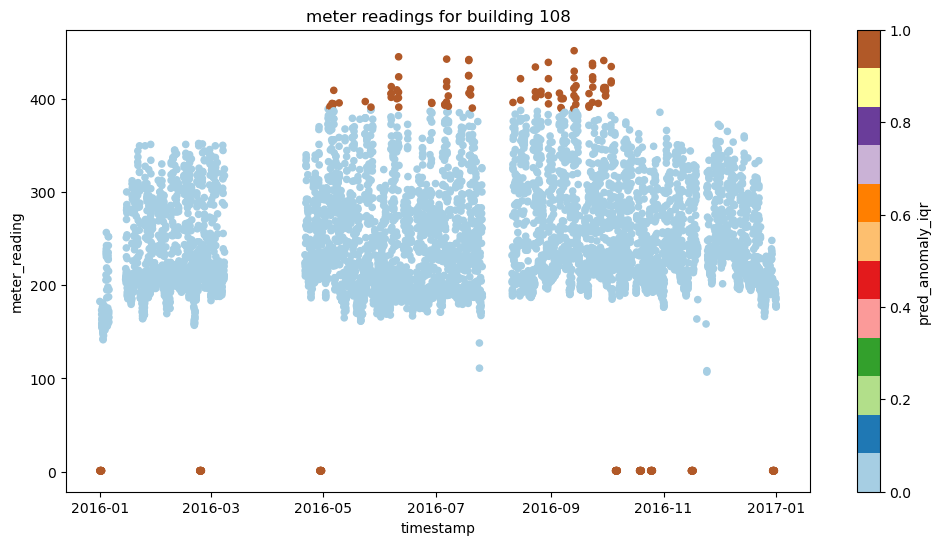

In [12]:
plot_anomalies(train_with_anomalies, building_id=108, pred_anomaly='pred_anomaly_iqr')